Index(['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window',
       'rocket', 'success', 'failures', 'details', 'crew', 'ships', 'capsules',
       'payloads', 'launchpad', 'flight_number', 'name', 'date_utc',
       'date_unix', 'date_local', 'date_precision', 'upcoming', 'cores',
       'auto_update', 'tbd', 'launch_library_id', 'id', 'fairings.reused',
       'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships',
       'links.patch.small', 'links.patch.large', 'links.reddit.campaign',
       'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery',
       'links.flickr.small', 'links.flickr.original', 'links.presskit',
       'links.webcast', 'links.youtube_id', 'links.article', 'links.wikipedia',
       'fairings'],
      dtype='object')
Logistic Regression Accuracy: 1.0
Best parameters for SVM: {'C': 0.1, 'kernel': 'rbf'}
SVM Accuracy: 1.0
Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_split': 5}
Decision Tree Accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
<ipython-input-2-af57290a0a10>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")


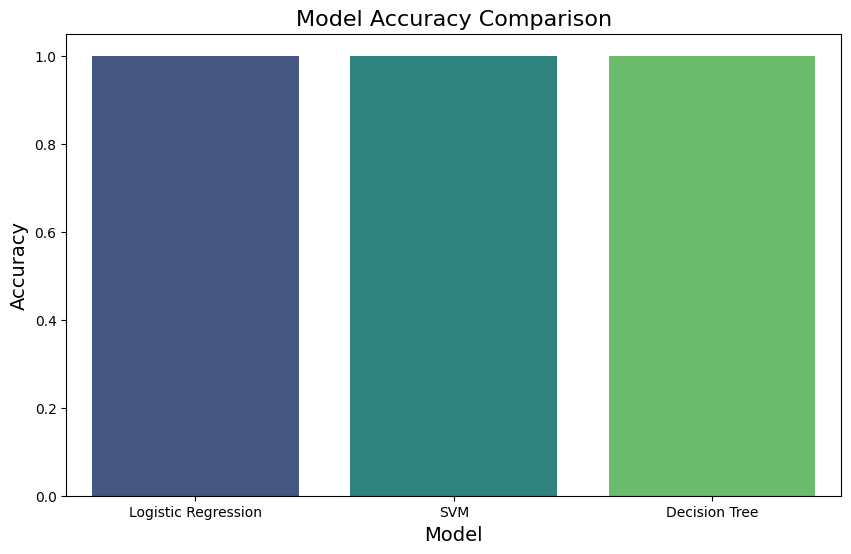

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Fetch data from SpaceX API
url = "https://api.spacexdata.com/v4/launches"
response = requests.get(url)
data = response.json()

# Step 2: Convert JSON data into a DataFrame
df = pd.json_normalize(data)

# Step 3: Inspect the columns to identify lists and nested structures
print(df.columns)

# Example: Flatten the 'payloads' column, assuming it contains a list of dictionaries
df['payload_count'] = df['payloads'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Optionally: You can extract specific features from the list, e.g., mass of payload
# df['payload_mass'] = df['payloads'].apply(lambda x: x[0]['mass_kg'] if isinstance(x, list) and len(x) > 0 else 0)

# Step 4: Preprocess the data and select relevant columns
df = df[['flight_number', 'payload_count', 'rocket', 'launchpad', 'success']]  # Modify based on available fields
df = df.dropna()  # Drop rows with missing values

# Convert 'success' (landing outcome) to 1 and 0 for classification
df['landing_success'] = df['success'].apply(lambda x: 1 if x else 0)

# Step 5: Prepare features (X) and target (y)
X = df[['payload_count', 'rocket', 'launchpad']]  # Use relevant features (modify this based on available data)
y = df['landing_success']

# Step 6: Convert categorical variables to dummy variables (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Standardize the features (important for models like SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Train different classification models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier()
}

# Step 10: Grid Search for hyperparameter tuning (optional, for improving models)
param_grid = {
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'Decision Tree': {'max_depth': [3, 5, 7, None], 'min_samples_split': [2, 5, 10]},
}

best_model = None
best_score = 0
accuracies = {}  # Store accuracy for each model

for model_name, model in models.items():
    # If the model is SVM or Decision Tree, perform grid search
    if model_name in param_grid:
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        model = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    # Train and evaluate the model
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Evaluate model
    score = model.score(X_test_scaled, y_test)
    accuracies[model_name] = score
    print(f"{model_name} Accuracy: {score}")

    if score > best_score:
        best_score = score
        best_model = model

# Step 11: Print confusion matrix and classification report for the best model
y_pred_best = best_model.predict(X_test_scaled)
print(f"Best Model: {best_model}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

# Step 12: Visualize the model accuracy for all classification models
model_names = list(accuracies.keys())
accuracy_scores = list(accuracies.values())

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")

# Add labels and title
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

# Show the plot
plt.show()
